In [2]:
import optuna
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_config(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def save_config(config, save_path):
    with open(save_path, "w") as f:
        json.dump(config, f)

def save_best_results(best_trial, model_name, cls_type, n_edges="default", dir="./best"):
    if not os.path.isdir(dir):
        os.makedirs(dir, exist_ok=True)
    
    config = load_config("./tune_cls.json")
    
    for key, value in best_trial.params.items():
        config[key] = value

    file_name = f"{model_name}_{n_edges}_{'GNN' if cls_type != 'MLP' else 'MLP'}"

    config["net_type"] = model_name
    config["cls_type"]= cls_type

    config["epochs"] = round(best_trial.user_attrs["avg_epoch"])

    if n_edges!="default":
        config["n_edges"] = n_edges

    keys_to_remove = []
    for key, value in config.items():
        if isinstance(value, list):
            keys_to_remove.append(key)

    for key in keys_to_remove:
        del config[key]

    save_config(config, f"./{dir}/{file_name}.json")

# def study_results(study_name, dir="./", sort_by ="f1", verbose=False, target_fn=lambda t: t.values[0]):
def study_results(study_name, dir="./", verbose=False):
    path = os.path.join(dir, f"{study_name}_study.db")

    study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{path}")

    if verbose:
        i = 0
        for trial in study.best_trials:
            print("Trial number ",i)
            print("\tBest mean values: ", trial.values)
            print("\tCustom metrics: ", trial.user_attrs)

            print("\tParams: ")
            for key, value in trial.params.items():
                print(f"\t\t{key}: {value}")
            i+=1
    # target=lambda x: x[1]
    # fig = optuna.visualization.plot_param_importances(study)
    # fig.show()
    
    # fig = optuna.visualization.plot_optimization_history(study, target=target_fn)
    # fig.show()

    return study.trials

def update_df_trials(t, model, n_edges, cls_type, finetuned_by):
    trials = sorted(t, key=lambda d: d.values[0] if finetuned_by =="macro-F1" else d.values[1], reverse=True)

    trials = trials[:1]

    for trial in trials:
        id = f"{model}_{n_edges}_{cls_type}_{trial.number}"

        if id not in df_trials["id"]:
            df_trials["id"].append(id)
            df_trials["f1"].append(trial.values[0])
            df_trials["chi"].append(trial.values[1])
            df_trials["model"].append(model)
            df_trials["n_edges"].append(n_edges)
            df_trials["cls_type"].append(cls_type)
            df_trials["finetuned_by"].append(finetuned_by)
        else:
            idx = df_trials["id"].index(id)
            df_trials["finetuned_by"][idx] = "both"


    return trials

df_trials = {
    "id":[],
    "model":[],
    "n_edges":[],
    "cls_type":[],
    "finetuned_by":[],
    "f1":[],
    "chi":[]
}

#### MLP

In [3]:
t = study_results("MLP", verbose=True)

trials = update_df_trials(t, "MLP", n_edges=0, cls_type="MLP", finetuned_by="macro-F1")
trials = update_df_trials(t, "MLP", n_edges=0, cls_type="MLP", finetuned_by="Chi-Square")
save_best_results(trials[0],"MLP","MLP",0,"best_chi")

Trial number  0
	Best mean values:  [0.9491341910556226, 21.776661849384393]
	Custom metrics:  {'avg_epoch': 63.8}
	Params: 
		batch_size: 32
		lr: 0.001
		wd: 0.001
		dp: 0.1
		norm: True
		ls: 16
Trial number  1
	Best mean values:  [0.9360735387152544, 23.91717532515846]
	Custom metrics:  {'avg_epoch': 70.0}
	Params: 
		batch_size: 32
		lr: 0.001
		wd: 0.001
		dp: 0.1
		norm: True
		ls: 16
Trial number  2
	Best mean values:  [0.9367182263728463, 22.489803801171774]
	Custom metrics:  {'avg_epoch': 74.4}
	Params: 
		batch_size: 32
		lr: 0.001
		wd: 0.001
		dp: 0.1
		norm: True
		ls: 16


#### GNN

In [4]:
n_edges = [0, 422, 1000, 2500, 5000]
gnn_models = ["GCN", "GAT", "GATv2"]
cls_type = ["GNN","MLP"]

for cls in cls_type:
    for model in gnn_models:
        for n in n_edges:

            t = study_results(f"{model}_{n}_{cls}", verbose=False)
            cls_layer = model if cls=="GNN" else cls

            trials = update_df_trials(t, model, n_edges=n, cls_type=cls, finetuned_by="macro-F1")
            trials = update_df_trials(t, model, n_edges=n, cls_type=cls, finetuned_by="Chi-Square")
            save_best_results(trials[0], model, cls_layer, n, f"best_chi")

## Best trial for all models

In [5]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(df_trials)
df["n_edges"] = df["n_edges"].fillna(0)
df.drop(df[df["f1"] ==0].index, inplace=True)
df = df.sort_values(["n_edges", "finetuned_by"])
df

,id,model,n_edges,cls_type,finetuned_by,f1,chi
1,MLP_0_MLP_79,MLP,0,MLP,Chi-Square,0.936074,23.917175
3,GCN_0_GNN_17,GCN,0,GNN,Chi-Square,0.923555,22.566035
13,GAT_0_GNN_32,GAT,0,GNN,Chi-Square,0.910732,21.848050
23,GATv2_0_GNN_87,GATv2,0,GNN,Chi-Square,0.932324,20.633239
33,GCN_0_MLP_24,GCN,0,MLP,Chi-Square,0.937459,22.603081
...,...,...,...,...,...,...,...
20,GAT_5000_GNN_38,GAT,5000,GNN,macro-F1,0.863845,6.006622
30,GATv2_5000_GNN_74,GATv2,5000,GNN,macro-F1,0.867486,10.019288
40,GCN_5000_MLP_32,GCN,5000,MLP,macro-F1,0.880418,4.882983
50,GAT_5000_MLP_95,GAT,5000,MLP,macro-F1,0.867532,5.557945


/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


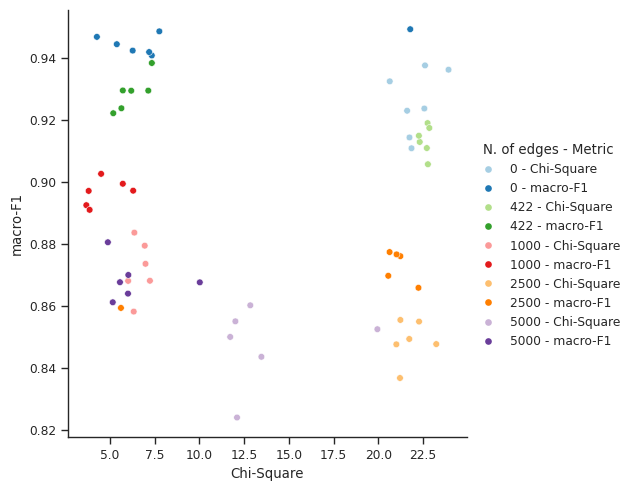

In [9]:
sns.set_theme(context='paper', style='ticks', palette=sns.color_palette())

hue = df[['n_edges', 'finetuned_by']].apply(
    lambda row: f"{row.n_edges} - {row.finetuned_by}", axis=1)
hue.name = 'N. of edges - Metric'
# sns.relplot(x='#', y='Attack', hue=hue, data=df)

sns.relplot(data=df, y="f1", x="chi", hue=hue,  palette=sns.color_palette("Paired",10))
# sns.rugplot(data=df, y="f1", x="chi", hue=hue,  palette=sns.color_palette("Paired",10))

plt.ylabel("macro-F1")
plt.xlabel("Chi-Square")
plt.savefig("../plots/f1_chi.png")
plt.show()

/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


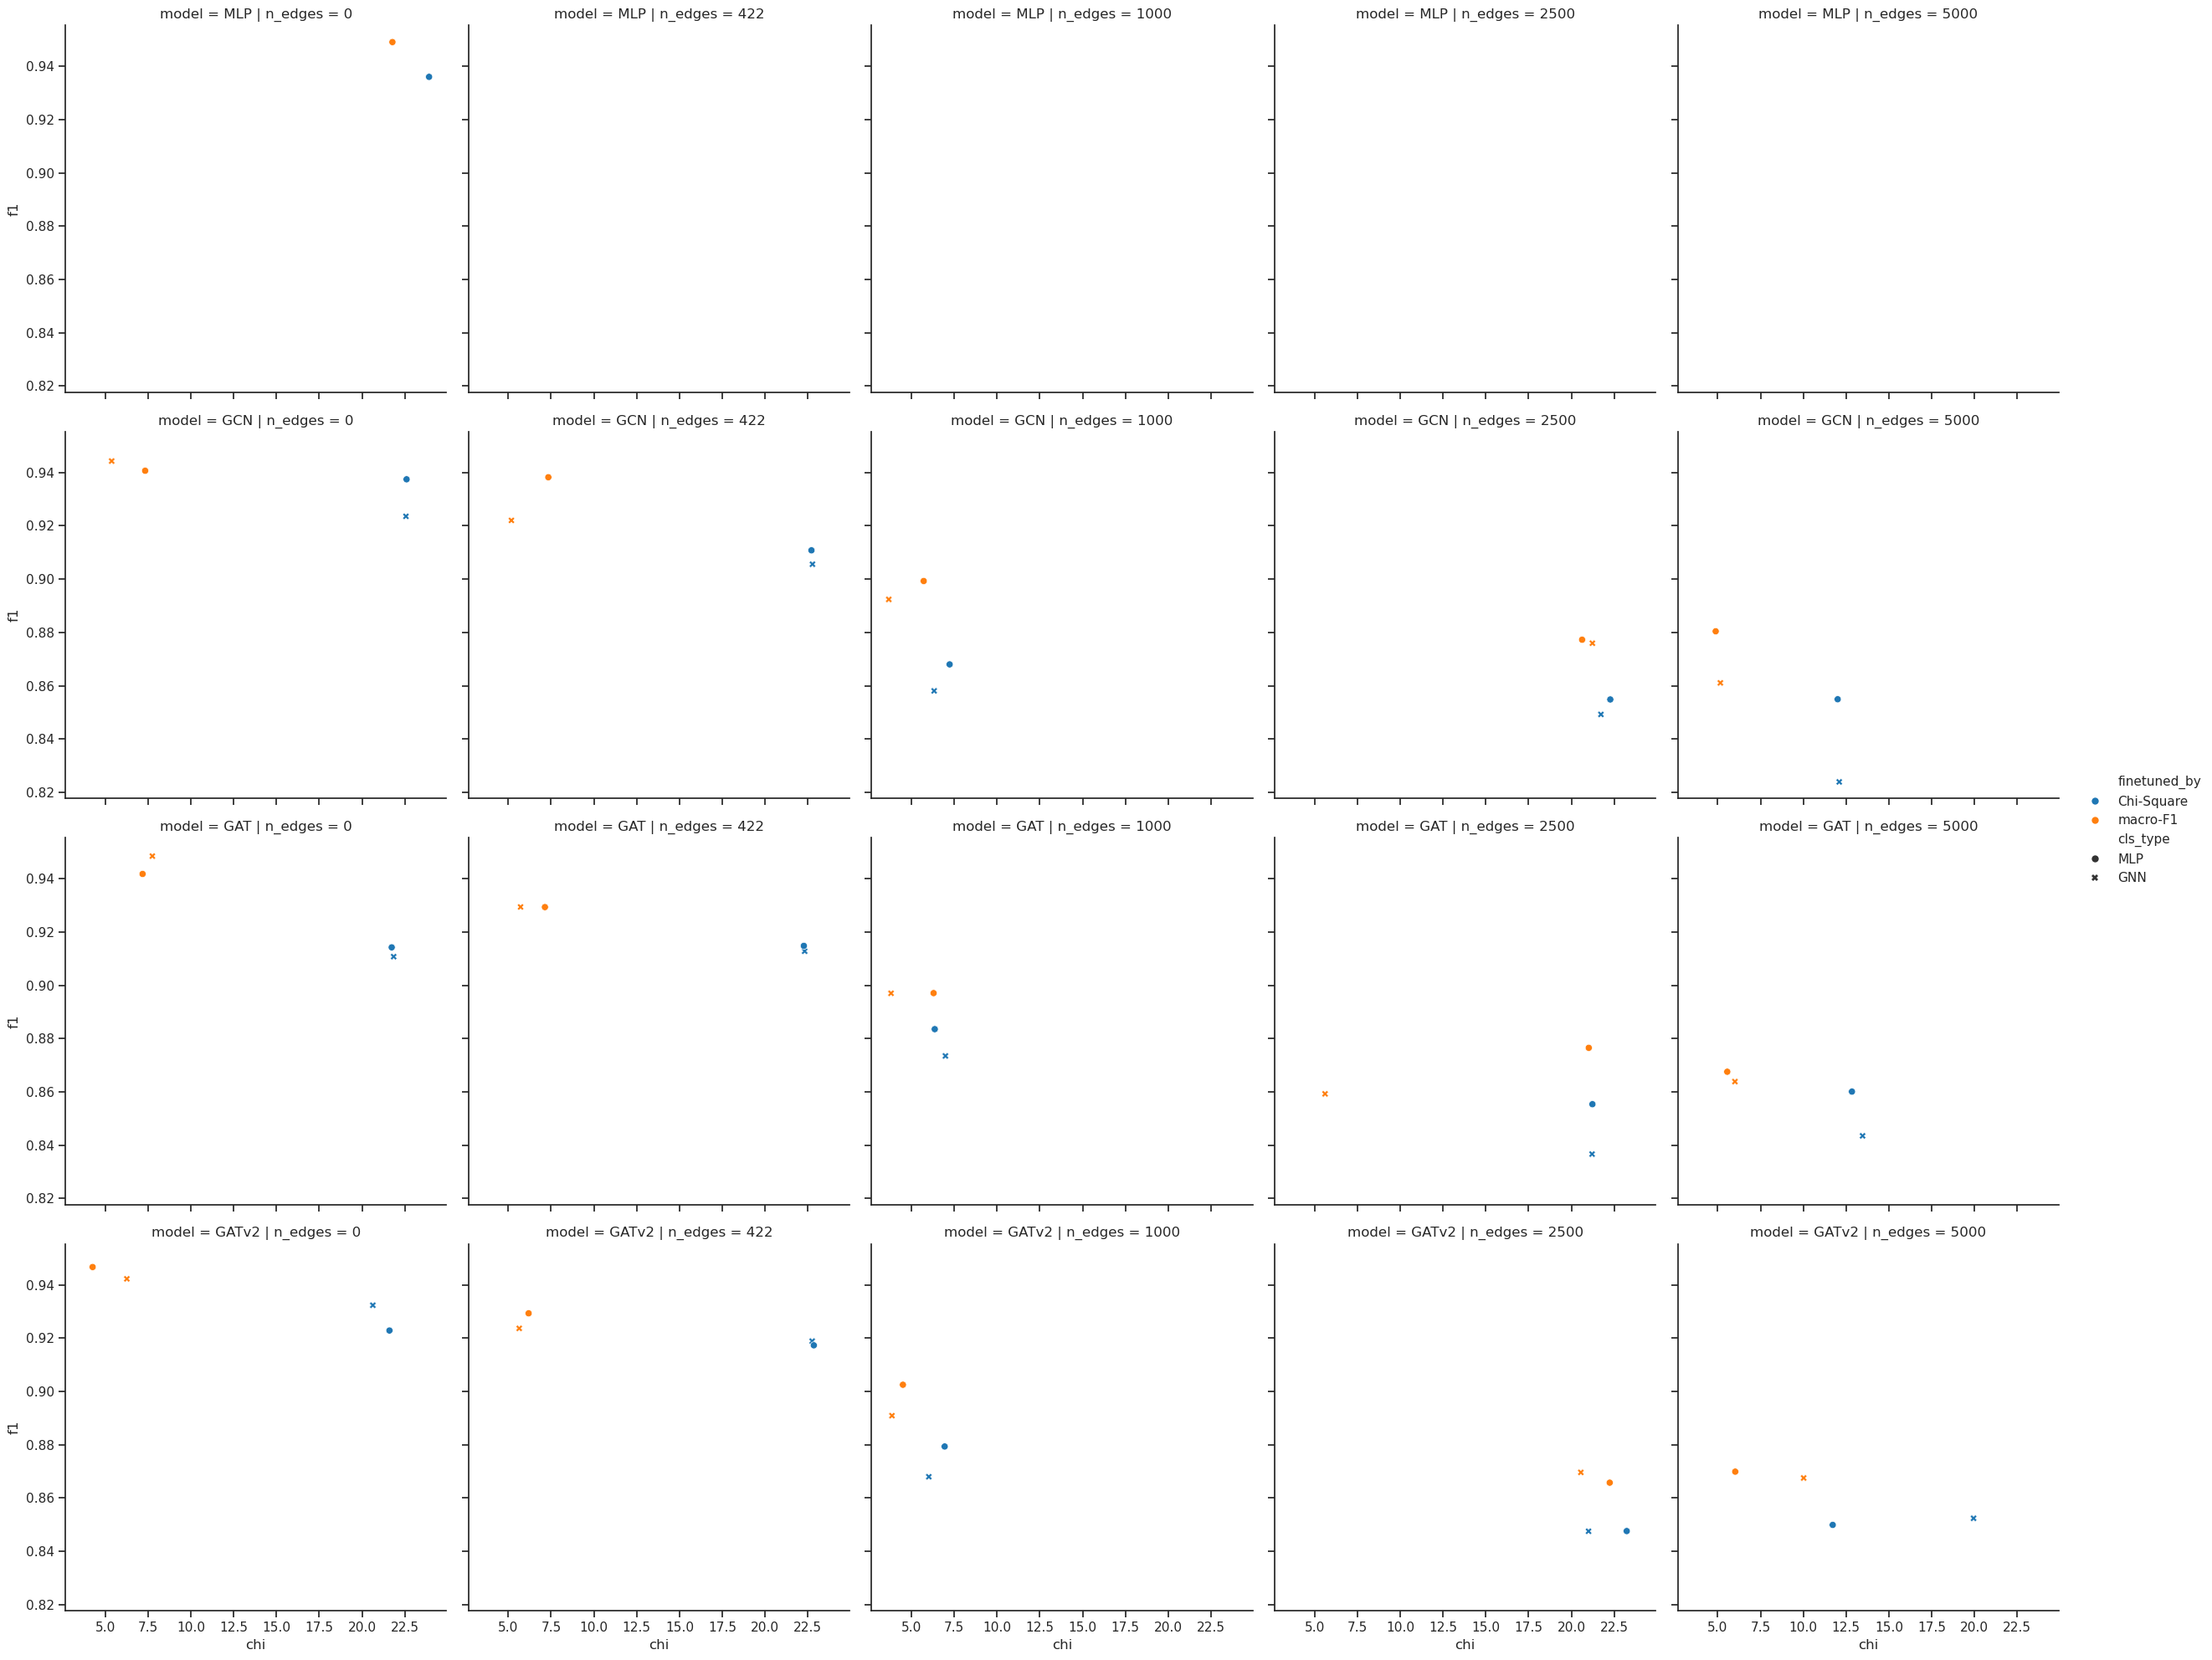

In [10]:
sns.set_theme(context='notebook', style='ticks', palette=sns.color_palette())

ax =sns.relplot(data=df, y="f1", x="chi",hue="finetuned_by", style="cls_type", col="n_edges", row="model",palette=sns.color_palette("tab10",2))
plt.savefig("../plots/f1_chi_supplementary.png")
plt.show()